# M3 - M4

## I- Préparation des données

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score

# Chargement des données
customers = pd.read_excel('../../customers_data_extended.xlsx')
sales = pd.read_excel('../../sales_data_extended.xlsx')

# Nettoyage des données de ventes (certains prix sont manquants)
sales = sales.dropna(subset=['Sale_Price'])

# Calcul du total dépensé par client à partir des données de vente
customer_spending = sales.groupby('Customer_ID').agg(
    total_spent=('Sale_Price', 'sum'),
    purchase_count=('Sale_ID', 'count'),
    avg_purchase_value=('Sale_Price', 'mean')
).reset_index()

# Jointure avec les données clients
df = pd.merge(customers, customer_spending, on='Customer_ID', how='left')

# Remplissage des valeurs manquantes pour les clients sans achats
df['total_spent'] = df['total_spent'].fillna(0)
df['purchase_count'] = df['purchase_count'].fillna(0)
df['avg_purchase_value'] = df['avg_purchase_value'].fillna(0)

# Conversion des variables catégorielles
df = pd.get_dummies(df, columns=['Gender', 'Location', 'Preferred_Channel'], drop_first=True)

# Sélection des features pour le clustering
features = ['Age', 'Income', 'Email_Open_Rate', 'total_spent', 'purchase_count', 'avg_purchase_value',
            'Gender_Male', 'Preferred_Channel_Online']
X = df[features]
print(X)

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


    Age  Income  Email_Open_Rate  total_spent  purchase_count  \
0    28   81254             0.48       150.00            1.00   
1    35  100000             0.89        25.00            1.00   
2    22   64520             0.24       150.00            1.00   
3    30   95000             0.62       442.50            4.00   
4    27   85604             0.50       386.50            4.00   
5    46   52662             0.43         0.00            0.00   
6    32   38392             0.70        60.00            1.00   
7    60   60535             0.69        75.00            1.00   
8    25  108603             0.35        90.00            1.00   
9    38   82256             0.71       300.00            3.00   
10   56  119135             0.66        75.00            1.00   
11   36   65222             0.84         0.00            0.00   
12   40  107373             0.86       309.00            3.00   
13   28  109575             0.32        25.00            1.00   
14   28  114651          

## II- K-mean Clustering

#### Methode de coude pour déterminer le nombre optimal de clusters et applications de k-mean

d:\Programmes\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Programmes\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Programmes\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Programmes\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with M

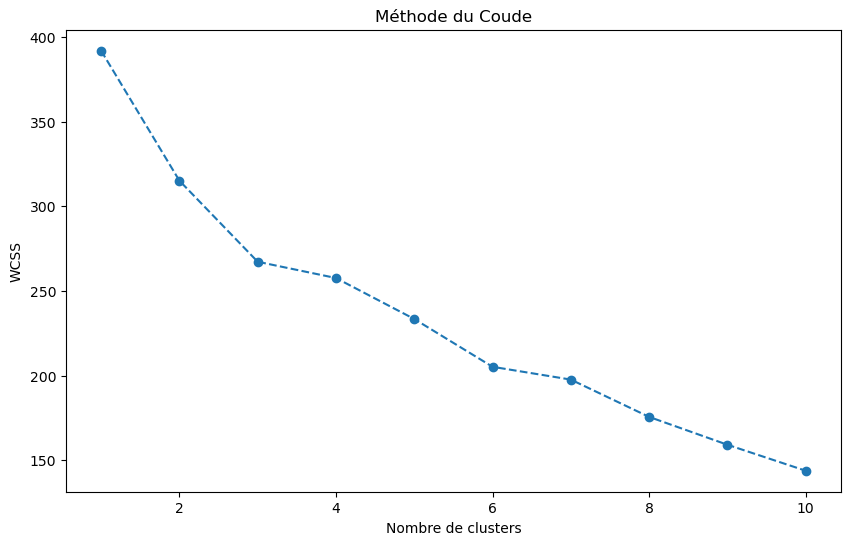

In [56]:
# Méthode du coude pour déterminer le nombre optimal de clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Méthode du Coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')
plt.savefig("nombre_optimal_methode_coude.png")
plt.show()

In [57]:
# Selon le graphique , le nombre optimal est 3 
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Ajout des clusters au dataframe
df['Cluster'] = clusters

# Analyse des clusters
cluster_stats = df.groupby('Cluster')[features].mean()
print(cluster_stats)

# Score de silhouette
silhouette_avg = silhouette_score(X_scaled, clusters)
print(f"Score de silhouette moyen: {silhouette_avg:.3f}")



d:\Programmes\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


          Age   Income  Email_Open_Rate  total_spent  purchase_count  \
Cluster                                                                
0       47.00 89708.61             0.75        66.33            1.06   
1       38.09 84902.55             0.76       530.59            3.55   
2       33.60 72593.75             0.58       138.95            1.30   

         avg_purchase_value  Gender_Male  Preferred_Channel_Online  
Cluster                                                             
0                     50.67         0.56                      0.94  
1                    162.56         0.36                      0.64  
2                    103.79         0.50                      0.20  
Score de silhouette moyen: 0.156


## III - PCA (Analyses en Composants Principales)

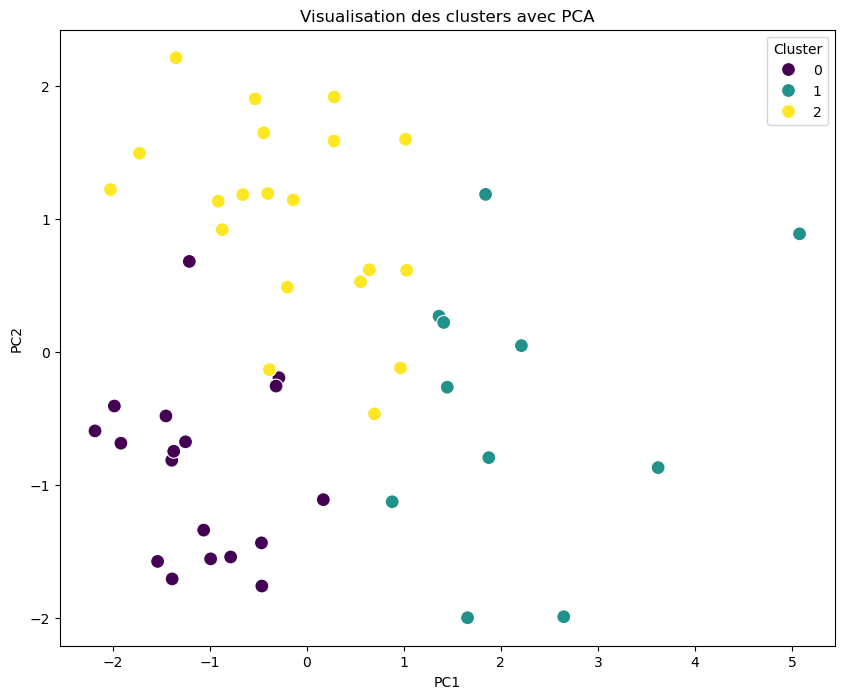

Variance expliquée par chaque composante: [0.28626874 0.16922317]


In [58]:
# Application de PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Création d'un dataframe avec les composantes principales
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters

# Visualisation
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', s=100)
plt.title('Visualisation des clusters avec PCA')
plt.savefig("pca_clusters.png")
plt.show()

# Variance expliquée
print(f"Variance expliquée par chaque composante: {pca.explained_variance_ratio_}")

## IV - Application de t-SNE

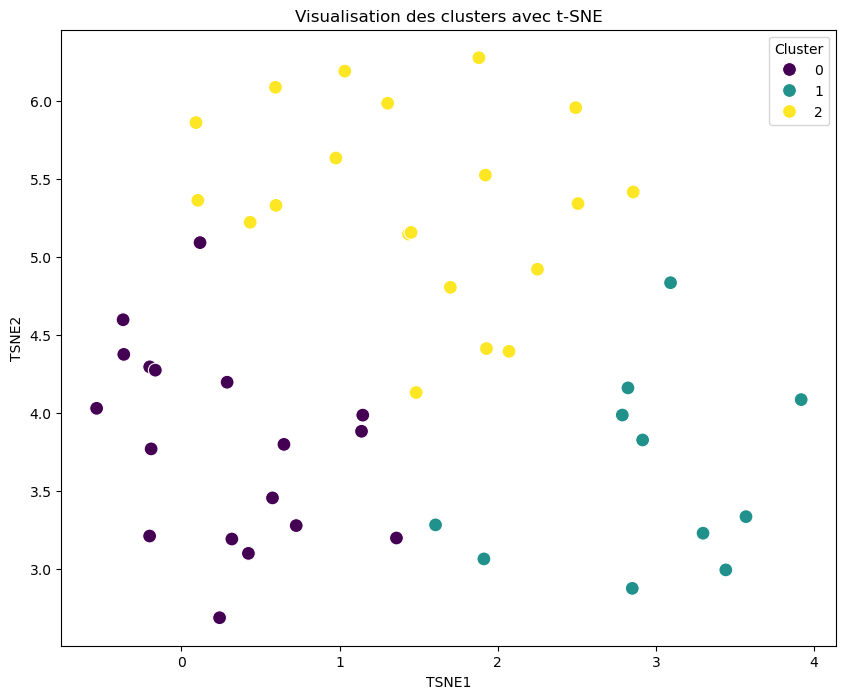

In [59]:
# Application de t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(X_scaled)

# Création d'un dataframe avec les résultats t-SNE
tsne_df = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['Cluster'] = clusters

# Visualisation
plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Cluster', data=tsne_df, palette='viridis', s=100)
plt.title('Visualisation des clusters avec t-SNE')
plt.savefig("t-SNE_clusters.png")
plt.show()

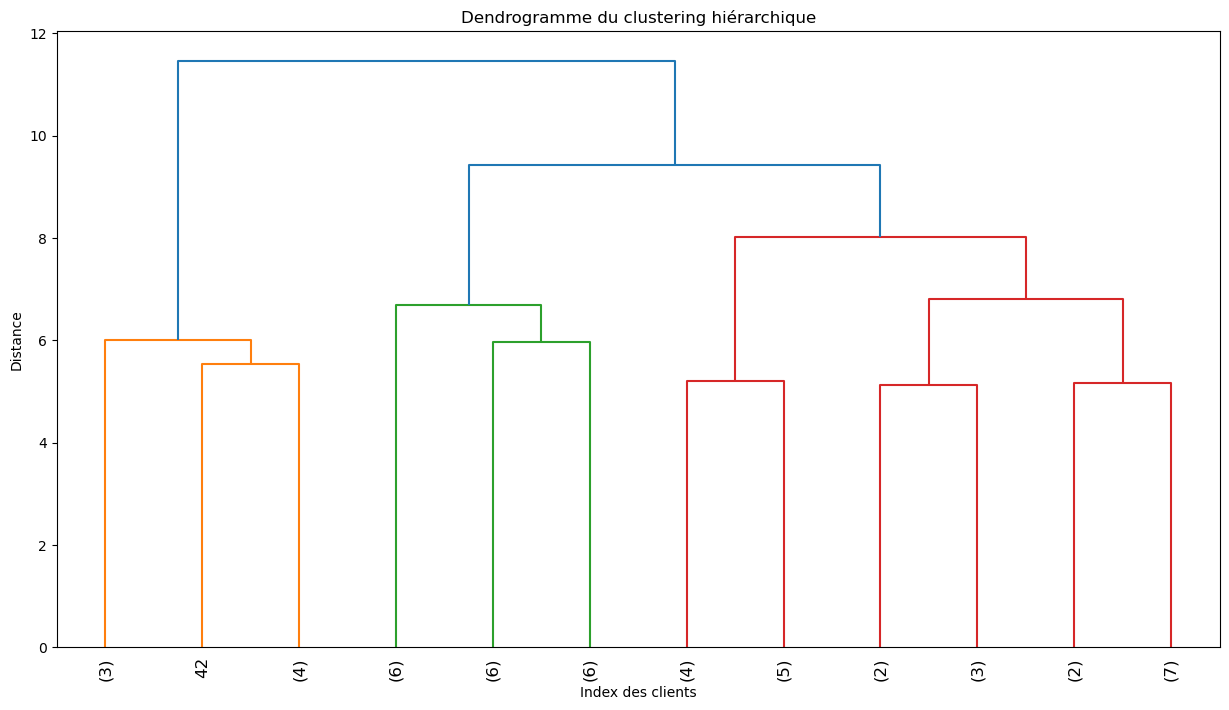

                       Age   Income  Email_Open_Rate  total_spent  \
Hierarchical_Cluster                                                
1                    35.00 79536.12             0.70       561.56   
2                    40.41 82055.34             0.68       129.68   

                      purchase_count  avg_purchase_value  Gender_Male  \
Hierarchical_Cluster                                                    
1                               4.00              145.96         0.12   
2                               1.27               88.01         0.56   

                      Preferred_Channel_Online  
Hierarchical_Cluster                            
1                                         0.50  
2                                         0.59  


In [60]:
# Calcul de la matrice de liaison
Z = linkage(X_scaled, method='ward')

# Dendrogramme
plt.figure(figsize=(15, 8))
dendrogram(Z, truncate_mode='lastp', p=12, show_leaf_counts=True, leaf_rotation=90, leaf_font_size=12)
plt.title('Dendrogramme du clustering hiérarchique')
plt.xlabel('Index des clients')
plt.ylabel('Distance')
plt.show()

# Découpage en clusters (par exemple à distance 10)
from scipy.cluster.hierarchy import fcluster
hierarchical_clusters = fcluster(Z, t=10, criterion='distance')
df['Hierarchical_Cluster'] = hierarchical_clusters

# Analyse des clusters hiérarchiques
hierarchical_stats = df.groupby('Hierarchical_Cluster')[features].mean()
print(hierarchical_stats)

## V - Interprétation des Résultats

In [61]:
# Statistiques descriptives par cluster
for cluster in sorted(df['Cluster'].unique()):
    print(f"\nCluster {cluster} - Caractéristiques moyennes:")
    print(df[df['Cluster'] == cluster][features].mean())
    
    print("\nExemples de clients dans ce cluster:")
    print(df[df['Cluster'] == cluster][['Customer_ID', 'Name', 'Age', 'Income', 'total_spent']].head(3))



Cluster 0 - Caractéristiques moyennes:
Age                           47.00
Income                     89708.61
Email_Open_Rate                0.75
total_spent                   66.33
purchase_count                 1.06
avg_purchase_value            50.67
Gender_Male                    0.56
Preferred_Channel_Online       0.94
dtype: float64

Exemples de clients dans ce cluster:
    Customer_ID             Name  Age  Income  total_spent
1          2002  Katherine Smith   35  100000        25.00
7          2008    Diane Morales   60   60535        75.00
10         2011      David Payne   56  119135        75.00

Cluster 1 - Caractéristiques moyennes:
Age                           38.09
Income                     84902.55
Email_Open_Rate                0.76
total_spent                  530.59
purchase_count                 3.55
avg_purchase_value           162.56
Gender_Male                    0.36
Preferred_Channel_Online       0.64
dtype: float64

Exemples de clients dans ce cluster:
  

## VI - Visualisation des profils de Clusters

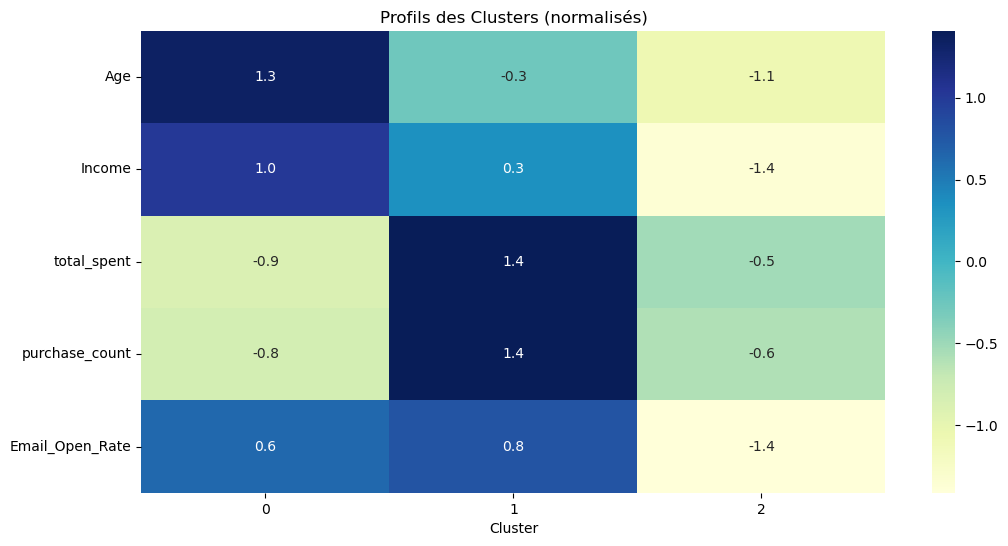

In [62]:
# Préparation des données pour la visualisation
cluster_profiles = df.groupby('Cluster')[['Age', 'Income', 'total_spent', 'purchase_count', 'Email_Open_Rate']].mean()

# Normalisation pour une meilleure visualisation
cluster_profiles_scaled = pd.DataFrame(
    scaler.fit_transform(cluster_profiles),
    columns=cluster_profiles.columns,
    index=cluster_profiles.index
)

# Heatmap des caractéristiques des clusters
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profiles_scaled.T, cmap='YlGnBu', annot=True, fmt=".1f")
plt.title('Profils des Clusters (normalisés)')
plt.savefig("clusters_profils.png")
plt.show()

## VII - M4 Analyse de profils et Personas 

In [63]:
# Sélection des caractéristiques importantes pour le profilage
profile_features = ['Age', 'Income', 'total_spent', 'purchase_count', 'Email_Open_Rate', 
                    'Gender_Male', 'Preferred_Channel_Online']

# Calcul des moyennes par cluster
cluster_profiles = df.groupby('Cluster')[profile_features].mean()

# Affichage des profils
pd.options.display.float_format = '{:.2f}'.format
print("Profil moyen de chaque segment:")
display(cluster_profiles)

# Calcul des tailles des clusters
cluster_sizes = df['Cluster'].value_counts().sort_index()
print("\nTaille des clusters:")
print(cluster_sizes)

Profil moyen de chaque segment:


,Age,Income,total_spent,purchase_count,Email_Open_Rate,Gender_Male,Preferred_Channel_Online
Cluster,,,,,,,
0,47.00,89708.61,66.33,1.06,0.75,0.56,0.94
1,38.09,84902.55,530.59,3.55,0.76,0.36,0.64
2,33.60,72593.75,138.95,1.30,0.58,0.50,0.20



Taille des clusters:
Cluster
0    18
1    11
2    20
Name: count, dtype: int64


### Visualisation des profils

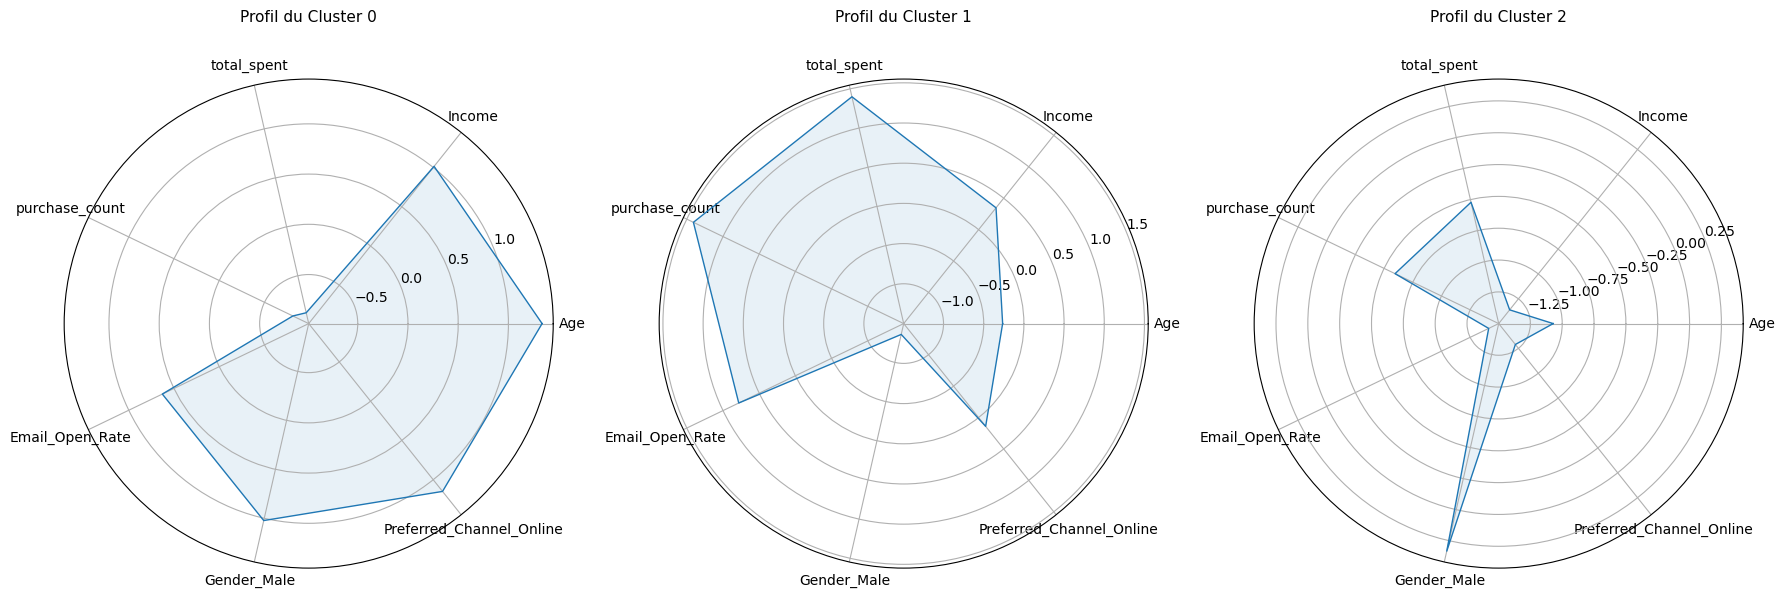

In [64]:
# Normalisation des données pour une meilleure visualisation
scaler = StandardScaler()
cluster_profiles_scaled = pd.DataFrame(
    scaler.fit_transform(cluster_profiles),
    columns=cluster_profiles.columns,
    index=cluster_profiles.index
)

# Radar chart pour comparer les clusters
def plot_radar_chart(cluster_num, ax):
    categories = list(cluster_profiles_scaled.columns)
    N = len(categories)
    
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    
    values = cluster_profiles_scaled.loc[cluster_num].values.flatten().tolist()
    values += values[:1]
    
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=f"Cluster {cluster_num}")
    ax.fill(angles, values, alpha=0.1)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_title(f"Profil du Cluster {cluster_num}", size=11, y=1.1)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw=dict(polar=True))
for i, ax in enumerate(axes):
    plot_radar_chart(i, ax)
plt.tight_layout()
plt.savefig("M4_radar_clusters_profil.png")
plt.show()

### Description des personas pour chaque cluster

In [ ]:
clusters_index = [0, 1, 2]
for i in clusters_index:
    print(f"\nProfil du Cluster {i}:")
    print("- Âge moyen jeune (autour de {:.1f} ans)".format(cluster_profiles.loc[i, 'Age']))
    print("- Dépenses totales élevées ({:.0f} en moyenne)".format(cluster_profiles.loc[i, 'total_spent']))
    print("- Forte préférence pour les canaux en ligne ({:.0%})".format(cluster_profiles.loc[i, 'Preferred_Channel_Online']))
    print("- Taux d'ouverture des emails moyen ({:.0%})".format(cluster_profiles.loc[i, 'Email_Open_Rate']))

    cluster = df[df['Cluster'] == i].sample(3, random_state=42)[['Name', 'Age', 'Income', 'total_spent', 'Preferred_Channel_Online']]
    print(f"Exemples de clients du Cluster {i}:")
    display(cluster)    



Profil du Cluster 0:
- Âge moyen jeune (autour de 47.0 ans)
- Dépenses totales élevées (66 en moyenne)
- Forte préférence pour les canaux en ligne (94%)
- Taux d'ouverture des emails moyen (75%)
Exemples de clients du Cluster {i}:


,Name,Age,Income,total_spent,Preferred_Channel_Online
1,Katherine Smith,35,100000,25.00,True
7,Diane Morales,60,60535,75.00,True
23,Stephanie Stout,61,112948,150.00,True



Profil du Cluster 1:
- Âge moyen jeune (autour de 38.1 ans)
- Dépenses totales élevées (531 en moyenne)
- Forte préférence pour les canaux en ligne (64%)
- Taux d'ouverture des emails moyen (76%)
Exemples de clients du Cluster {i}:


,Name,Age,Income,total_spent,Preferred_Channel_Online
26,Melissa Warren MD,19,117054,375.00,True
3,Luke Lewis,30,95000,442.50,False
42,Kirk Francis,24,105450,1101.00,False



Profil du Cluster 2:
- Âge moyen jeune (autour de 33.6 ans)
- Dépenses totales élevées (139 en moyenne)
- Forte préférence pour les canaux en ligne (20%)
- Taux d'ouverture des emails moyen (58%)
Exemples de clients du Cluster {i}:


,Name,Age,Income,total_spent,Preferred_Channel_Online
0,Andrew Perez,28,81254,150.00,True
43,Elizabeth Olson,38,52299,202.50,False
37,Raymond Hensley,32,97214,50.00,False
